# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - Learning rate Scheduler 활용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - batch size: 128
    - Epoch: 100
    - EarlyStopping 적용
      - 사용자 정의 모듈
      - https://github.com/Bjarten/early-stopping-pytorch

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스

class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False,drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 ResNet50 모델 호출 -> head 부분 수정
def build_resnet50_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.resnet50(pretrained = True) # 이미 학습된 resnet50 모델 불러오기
    
    # 일반 NN layer(FC layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))
    model.fc = nn.Linear(2048,7) # 7개의 감정으로 분류
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_resnet50_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1,
                                                       min_lr = 1e-12,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 20, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

0/227 - Running loss: 2.0532052516937256
30/227 - Running loss: 2.2139792442321777
60/227 - Running loss: 1.8460586071014404
90/227 - Running loss: 1.8177649974822998
120/227 - Running loss: 1.8143084049224854
150/227 - Running loss: 1.8161464929580688
180/227 - Running loss: 1.7937649488449097
210/227 - Running loss: 1.7668423652648926
1/100-Train Loss:1.952929985155618, Val Loss:1.8438689544283111
1/100-Train Acc:0.2510669052863436, Val Acc:0.2601137857977791
0/227 - Running loss: 1.8065788745880127
30/227 - Running loss: 1.8808631896972656
60/227 - Running loss: 1.871044635772705
90/227 - Running loss: 1.8198977708816528
120/227 - Running loss: 1.746478796005249
150/227 - Running loss: 1.8290369510650635
180/227 - Running loss: 1.7718961238861084
210/227 - Running loss: 1.6929855346679688
2/100-Train Loss:1.7798189591731268, Val Loss:1.7625811428859317
2/100-Train Acc:0.28383122246696035, Val Acc:0.3064545587375804
0/227 - Running loss: 1.78342866897583
30/227 - Running loss: 1.7025

30/227 - Running loss: 0.9763649702072144
60/227 - Running loss: 1.0435545444488525
90/227 - Running loss: 1.08006751537323
120/227 - Running loss: 0.9136377573013306
150/227 - Running loss: 0.9012898206710815
180/227 - Running loss: 1.126002550125122
210/227 - Running loss: 0.8559163212776184
18/100-Train Loss:1.0273073186958415, Val Loss:1.0870647379036606
18/100-Train Acc:0.6156731828193832, Val Acc:0.5930650935125658
0/227 - Running loss: 1.012732744216919
30/227 - Running loss: 0.9596965312957764
60/227 - Running loss: 1.01487398147583
90/227 - Running loss: 0.9739762544631958
120/227 - Running loss: 0.8935762643814087
150/227 - Running loss: 0.9647490382194519
180/227 - Running loss: 1.1185473203659058
210/227 - Running loss: 0.9415706992149353
19/100-Train Loss:0.9840338581984264, Val Loss:1.0823556688325158
19/100-Train Acc:0.6340859030837004, Val Acc:0.5957133985973115
0/227 - Running loss: 1.0975868701934814
30/227 - Running loss: 1.035814642906189
60/227 - Running loss: 0.95

180/227 - Running loss: 0.658694863319397
210/227 - Running loss: 0.5293254256248474
EarlyStopping counter: 9 out of 20
34/100-Train Loss:0.6975856420752236, Val Loss:1.078167655344667
34/100-Train Acc:0.7458012114537445, Val Acc:0.6138999488603156
0/227 - Running loss: 0.5078351497650146
30/227 - Running loss: 0.8510018587112427
60/227 - Running loss: 0.8584351539611816
90/227 - Running loss: 0.6847532391548157
120/227 - Running loss: 0.6593944430351257
150/227 - Running loss: 0.652715802192688
180/227 - Running loss: 0.778840184211731
210/227 - Running loss: 0.7265211343765259
EarlyStopping counter: 10 out of 20
35/100-Train Loss:0.6905592257230817, Val Loss:1.082428632111385
35/100-Train Acc:0.7468337004405287, Val Acc:0.6141236849795441
0/227 - Running loss: 0.7173459529876709
30/227 - Running loss: 0.7563859224319458
60/227 - Running loss: 0.7275841236114502
90/227 - Running loss: 0.6608666181564331
120/227 - Running loss: 0.7463729977607727
150/227 - Running loss: 0.6848069429397

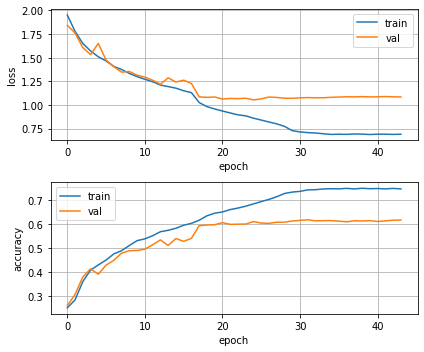

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()